In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
# ✅ Preprocess Function
def preprocess_signature(img_path, img_size=155):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype("float32") / 255.0
    return img.reshape(img_size, img_size, 1)


In [3]:
# ✅ Load Dataset (separate genuine & forged)
def load_dataset(base_path):
    genuine_paths, forged_paths = [], []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(".jpg"):
                path = os.path.join(root, file)
                if "forge" in root.lower():
                    forged_paths.append(path)
                else:
                    genuine_paths.append(path)
    return genuine_paths, forged_paths

In [4]:
# ✅ Create Image Pairs (Positive + Negative)
def create_pairs(genuine_paths, forged_paths, img_size=155):
    pairs_1, pairs_2, labels = [], [], []
    datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        fill_mode='nearest'
    )

    min_len = min(len(genuine_paths), len(forged_paths))

    for i in range(min_len):
        # Positive pair (genuine vs genuine)
        img1 = preprocess_signature(genuine_paths[i], img_size)
        img2 = preprocess_signature(genuine_paths[(i + 1) % min_len], img_size)
        img1 = datagen.random_transform(img1)
        img2 = datagen.random_transform(img2)
        pairs_1.append(img1)
        pairs_2.append(img2)
        labels.append(1)

        # Negative pair (genuine vs forged)
        img1 = preprocess_signature(genuine_paths[i], img_size)
        img2 = preprocess_signature(forged_paths[i], img_size)
        img1 = datagen.random_transform(img1)
        img2 = datagen.random_transform(img2)
        pairs_1.append(img1)
        pairs_2.append(img2)
        labels.append(0)

    return np.array(pairs_1), np.array(pairs_2), np.array(labels)


In [5]:
# ✅ Build Base CNN
def build_base_cnn(input_shape=(155,155,1)):
    inp = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = MaxPooling2D(2,2)(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    return Model(inp, x)

In [6]:
# ✅ Load Data
DATASET = "SIGNATURE/train"
genuine, forged = load_dataset(DATASET)
print(f"✅ Found Genuine: {len(genuine)} | Forged: {len(forged)}")

✅ Found Genuine: 2400 | Forged: 2400


In [7]:
# ✅ Create Pairs & Split 70/15/15
X1, X2, y = create_pairs(genuine, forged)

X1_train, X1_temp, X2_train, X2_temp, y_train, y_temp = train_test_split(X1, X2, y, test_size=0.30, random_state=42)
X1_val, X1_test, X2_val, X2_test, y_val, y_test = train_test_split(X1_temp, X2_temp, y_temp, test_size=0.50, random_state=42)

print("✅ Dataset Split Shapes:")
print("Train:", X1_train.shape)
print("Validation:", X1_val.shape)
print("Test:", X1_test.shape)


✅ Dataset Split Shapes:
Train: (3360, 155, 155, 1)
Validation: (720, 155, 155, 1)
Test: (720, 155, 155, 1)


In [8]:
# ✅ Build Siamese Model
base_cnn = build_base_cnn()

input_A = Input(shape=(155,155,1))
input_B = Input(shape=(155,155,1))

feat_A = base_cnn(input_A)
feat_B = base_cnn(input_B)

# ✅ FIXED Lambda Layer (added output_shape to prevent load errors)
distance = Lambda(
    lambda tensors: K.abs(tensors[0] - tensors[1]),
    output_shape=lambda s: s[0]
)([feat_A, feat_B])

output = Dense(1, activation="sigmoid")(distance)
model = Model([input_A, input_B], output)
model.compile(optimizer=Adam(0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 155, 155,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 155, 155,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │ 11,955,072 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,955,201 (45.61 MB)

 Trainable params: 11,955,201 (45.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ✅ Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [10]:
# ✅ Train Model
history = model.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_val, X2_val], y_val),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.4997 - loss: 0.6957 - val_accuracy: 0.5514 - val_loss: 0.6930 - learning_rate: 1.0000e-04
Epoch 2/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.4970 - loss: 0.6935 - val_accuracy: 0.5417 - val_loss: 0.6930 - learning_rate: 1.0000e-04
Epoch 3/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.5235 - loss: 0.6928 - val_accuracy: 0.5986 - val_loss: 0.6913 - learning_rate: 1.0000e-04
Epoch 4/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.5333 - loss: 0.6915 - val_accuracy: 0.5819 - val_loss: 0.6884 - learning_rate: 1.0000e-04
Epoch 5/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5658 - loss: 0.6806 - val_accuracy: 0.5889 - val_loss: 0.6697 - learning_rate: 1.0000e-04
Epoch 6/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6190 - loss: 0.6549 - val_accuracy: 0.5958 - val_loss: 0.6466 - learning_rate: 1.0000e-04
Epoch 7/40
105/105 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - acc

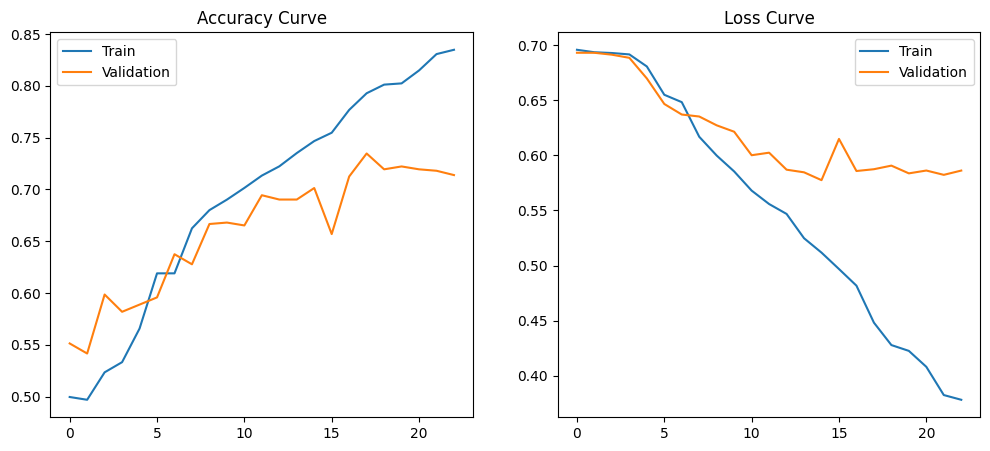

In [12]:
# ✅ Accuracy & Loss Graphs
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss Curve")
plt.legend()
plt.show()

In [13]:
# ✅ Final Testing Evaluation
test_loss, test_acc = model.evaluate([X1_test, X2_test], y_test, verbose=0)
print(f"\n✅ Final Test Accuracy: {test_acc*100:.2f}%")


✅ Final Test Accuracy: 73.89%


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step


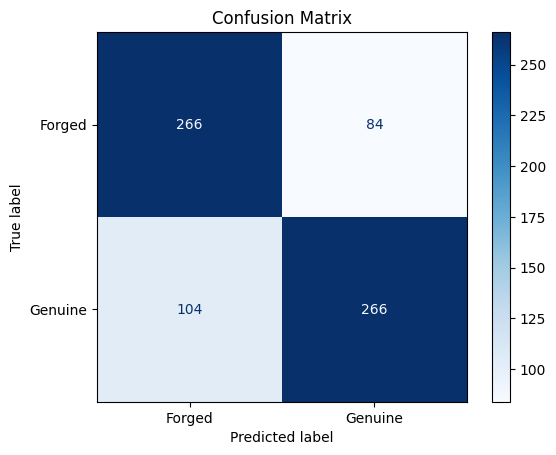

In [14]:
# ✅ Confusion Matrix
y_pred = (model.predict([X1_test, X2_test]) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Forged","Genuine"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# ✅ Save Model (Fixed)
model.save("signature.keras")
print("\n✅ Model saved successfully as 'signature.keras'")


✅ Model saved successfully as 'signature.h5'
